In [3]:
import pandas as pd
import numpy as np
import random
from faker import Faker

# Initialize faker for synthetic names
fake = Faker()

# Parameters
n_rows = 11000
start_date = pd.to_datetime("2023-01-01")
end_date = pd.to_datetime("2024-12-31")

# Categories and products
categories = {
    "Electronics": ["Laptop", "Smartphone", "Tablet", "Headphones", "Camera"],
    "Furniture": ["Office Chair", "Desk", "Sofa", "Bookshelf", "Dining Table"],
    "Clothing": ["T-Shirt", "Jeans", "Jacket", "Dress", "Shoes"],
    "Beauty": ["Perfume", "Lipstick", "Shampoo", "Face Cream", "Hair Oil"],
    "Sports": ["Football", "Tennis Racket", "Basketball", "Running Shoes", "Yoga Mat"]
}

regions = ["North", "South", "East", "West"]
payment_methods = ["Credit Card", "Debit Card", "PayPal", "Cash"]

# Generate rows
data = []
for i in range(1, n_rows+1):
    order_id = 10000 + i
    order_date = fake.date_between(start_date=start_date, end_date=end_date)
    customer_id = f"C{random.randint(1,500):03d}"
    customer_name = fake.name()
    region = random.choice(regions)
    category = random.choice(list(categories.keys()))
    product = random.choice(categories[category])
    quantity = random.randint(1, 20)
    
    # Price ranges by category
    if category == "Electronics":
        unit_price = random.randint(200, 1000)
    elif category == "Furniture":
        unit_price = random.randint(100, 800)
    elif category == "Clothing":
        unit_price = random.randint(20, 200)
    elif category == "Beauty":
        unit_price = random.randint(10, 150)
    else:  # Sports
        unit_price = random.randint(30, 500)
    
    discount = round(random.uniform(0, 0.3), 2)
    payment = random.choice(payment_methods)
    shipping_cost = random.randint(5, 100)
    total_sales = round(quantity * unit_price * (1 - discount) + shipping_cost, 2)
    
    data.append([
        order_id, order_date, customer_id, customer_name, region,
        category, product, quantity, unit_price, discount,
        payment, shipping_cost, total_sales
    ])

# Create DataFrame
columns = ["OrderID", "OrderDate", "CustomerID", "CustomerName", "Region",
           "ProductCategory", "ProductName", "Quantity", "UnitPrice", "Discount",
           "PaymentMethod", "ShippingCost", "TotalSales"]

df = pd.DataFrame(data, columns=columns)

# Save to Excel
df.to_excel("ecommerce_sales_11000.xlsx", index=False)

print("Dataset generated: ecommerce_sales_11000.xlsx")

Dataset generated: ecommerce_sales_11000.xlsx


In [5]:

# !pip install pandas numpy matplotlib seaborn openpyxl

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

pd.set_option("display.max_columns", 100)

# Load data
file_path = "ecommerce_sales_11000.xlsx"
df = pd.read_excel(file_path)

# Quick peek
print(df.shape)
df.head()
df.info()


(11000, 13)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11000 entries, 0 to 10999
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   OrderID          11000 non-null  int64         
 1   OrderDate        11000 non-null  datetime64[ns]
 2   CustomerID       11000 non-null  object        
 3   CustomerName     11000 non-null  object        
 4   Region           11000 non-null  object        
 5   ProductCategory  11000 non-null  object        
 6   ProductName      11000 non-null  object        
 7   Quantity         11000 non-null  int64         
 8   UnitPrice        11000 non-null  int64         
 9   Discount         11000 non-null  float64       
 10  PaymentMethod    11000 non-null  object        
 11  ShippingCost     11000 non-null  int64         
 12  TotalSales       11000 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(4), object(6)
memory usage: 1.1+ MB


In [6]:
# Ensure correct dtypes
df["OrderDate"] = pd.to_datetime(df["OrderDate"], errors="coerce")

# Convert categorical-like fields
cat_cols = ["Region", "ProductCategory", "ProductName", "PaymentMethod", "CustomerID"]
for c in cat_cols:
    df[c] = df[c].astype("category")

# Numeric columns
num_cols = ["Quantity", "UnitPrice", "Discount", "ShippingCost", "TotalSales"]
df[num_cols] = df[num_cols].apply(pd.to_numeric, errors="coerce")

# Basic constraints (domain checks)
assert df["Quantity"].ge(1).all(), "Found Quantity < 1"
assert df["UnitPrice"].ge(0).all(), "Found negative UnitPrice"
assert df["Discount"].between(0, 1).all(), "Discount outside [0,1]"
assert df["ShippingCost"].ge(0).all(), "Found negative ShippingCost"

# Recompute TotalSales to validate
calc_total = df["Quantity"] * df["UnitPrice"] * (1 - df["Discount"]) + df["ShippingCost"]
mismatch_rate = np.mean(np.isclose(calc_total, df["TotalSales"], rtol=1e-6) == False)
print(f"TotalSales mismatch rate: {mismatch_rate:.4%}")

TotalSales mismatch rate: 0.0000%


In [7]:
df["TotalSales"] = calc_total.round(2)

In [8]:
# Missing overview
missing = df.isnull().sum().sort_values(ascending=False)
missing

# Drop rows with missing OrderID or OrderDate (critical)
df = df.dropna(subset=["OrderID", "OrderDate"])

# Handle missing categoricals: fill with "Unknown"
fill_unknown = ["Region", "ProductCategory", "ProductName", "PaymentMethod"]
for c in fill_unknown:
    df[c] = df[c].cat.add_categories(["Unknown"]).fillna("Unknown")

# Handle numeric missing: conservative imputation
df["Discount"] = df["Discount"].fillna(0.0)
df["ShippingCost"] = df["ShippingCost"].fillna(df["ShippingCost"].median())
df["UnitPrice"] = df["UnitPrice"].fillna(df.groupby("ProductName")["UnitPrice"].transform("median"))
df["Quantity"] = df["Quantity"].fillna(1)

# Duplicates
dups = df.duplicated(subset=["OrderID", "ProductName", "Quantity", "UnitPrice", "OrderDate"])
print(f"Duplicate rows: {dups.sum()}")
df = df.loc[~dups].copy()

Duplicate rows: 0


C:\Users\pn02794\AppData\Local\Temp\ipykernel_13636\4234628354.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df["UnitPrice"] = df["UnitPrice"].fillna(df.groupby("ProductName")["UnitPrice"].transform("median"))


In [9]:
# Sanity: Quantity, UnitPrice, TotalSales should align
assert (df["Quantity"] <= 100).all(), "Unusually high Quantity detected"  # adjust threshold if needed
assert (df["UnitPrice"] <= 5000).all(), "Unusually high UnitPrice detected"  # adjust per domain

# Date-derived fields
df["Year"] = df["OrderDate"].dt.year
df["Month"] = df["OrderDate"].dt.month
df["MonthStart"] = df["OrderDate"].dt.to_period("M").dt.to_timestamp()
df["Week"] = df["OrderDate"].dt.isocalendar().week

# Flags
df["IsDiscounted"] = (df["Discount"] > 0).astype(int)
df["IsFreeShipping"] = (df["ShippingCost"] == 0).astype(int)

In [10]:
def cap_outliers(s, factor=1.5):
    q1, q3 = s.quantile([0.25, 0.75])
    iqr = q3 - q1
    low, high = q1 - factor*iqr, q3 + factor*iqr
    return s.clip(lower=low, upper=high)

for col in ["Quantity", "UnitPrice", "ShippingCost", "TotalSales"]:
    df[col] = cap_outliers(df[col])

# Optional: log-transform for visuals
df["TotalSales_log"] = np.log1p(df["TotalSales"])

C:\Users\pn02794\AppData\Local\Temp\ipykernel_13636\3799128744.py:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  top_products = (df.groupby("ProductName")["TotalSales"]
C:\Users\pn02794\AppData\Local\Temp\ipykernel_13636\3799128744.py:25: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  region_rev = df.groupby("Region")["TotalSales"].sum().sort_values(ascending=False)


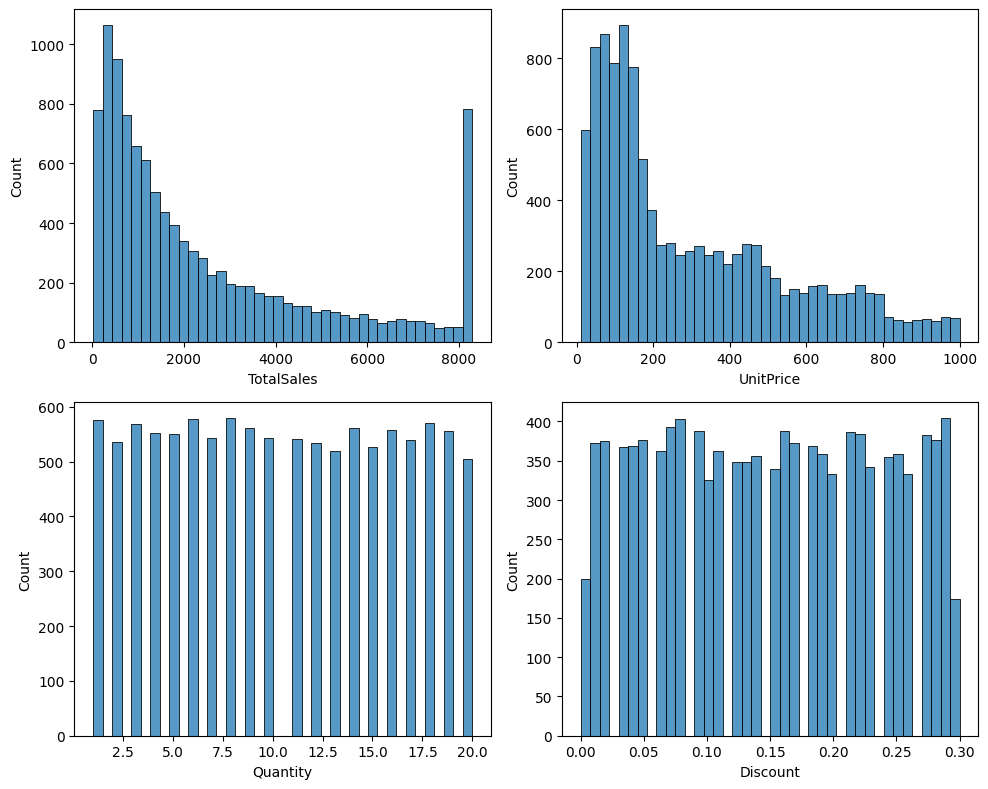

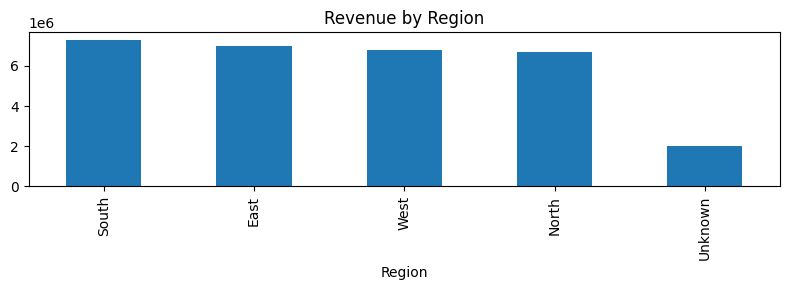

In [11]:
# Quick Exploratory Analysis 
# Distributions
fig, axes = plt.subplots(2, 2, figsize=(10, 8))
sns.histplot(df["TotalSales"], bins=40, ax=axes[0,0])
sns.histplot(df["UnitPrice"], bins=40, ax=axes[0,1])
sns.histplot(df["Quantity"], bins=40, ax=axes[1,0])
sns.histplot(df["Discount"], bins=40, ax=axes[1,1])
plt.tight_layout()

# Monthly revenue trend
monthly_rev = df.groupby("MonthStart")["TotalSales"].sum()
plt.figure(figsize=(10,4))
sns.lineplot(x=monthly_rev.index, y=monthly_rev.values)
plt.title("Monthly Revenue")

# Top products
top_products = (df.groupby("ProductName")["TotalSales"]
                  .sum()
                  .sort_values(ascending=False)
                  .head(10))
top_products.plot(kind="bar", figsize=(10,4), title="Top 10 Products by Revenue")
plt.tight_layout()

# Regional split
region_rev = df.groupby("Region")["TotalSales"].sum().sort_values(ascending=False)
region_rev.plot(kind="bar", figsize=(8,3), title="Revenue by Region")
plt.tight_layout()

In [12]:
# Consistency: totals by different groupings should sum to global total
total = df["TotalSales"].sum()
checks = {
    "By month": monthly_rev.sum(),
    "By region": region_rev.sum(),
    "By product": df.groupby("ProductName")["TotalSales"].sum().sum()
}
for k, v in checks.items():
    print(k, np.isclose(v, total))

# Check unique counts
print("Unique orders:", df["OrderID"].nunique())
print("Unique customers:", df["CustomerID"].nunique())
print("Unique products:", df["ProductName"].nunique())

By month True
By region True
By product True
Unique orders: 11000
Unique customers: 500
Unique products: 25


C:\Users\pn02794\AppData\Local\Temp\ipykernel_13636\4203561971.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  "By product": df.groupby("ProductName")["TotalSales"].sum().sum()


In [13]:
True

True

In [14]:
cost_pct = {
    "Electronics": 0.70, "Furniture": 0.60, "Clothing": 0.50, "Beauty": 0.40, "Sports": 0.55, "Unknown": 0.55
}
df["CostPct"] = df["ProductCategory"].astype(str).map(cost_pct).fillna(0.55)
df["EstimatedCost"] = df["Quantity"]*df["UnitPrice"]*df["CostPct"] + df["ShippingCost"]
df["GrossProfit"] = df["TotalSales"] - df["EstimatedCost"]
df["GrossMarginPct"] = (df["GrossProfit"] / df["TotalSales"]).replace([np.inf, -np.inf], np.nan)

In [15]:
# Minimal cleaned dataset
cols_clean = [
    "OrderID","OrderDate","CustomerID","Region","ProductCategory","ProductName",
    "Quantity","UnitPrice","Discount","ShippingCost","TotalSales",
    "Year","Month","MonthStart","Week","IsDiscounted","IsFreeShipping"
]
df_clean = df[cols_clean].copy()
df_clean.to_excel("ecommerce_sales_clean.xlsx", index=False)

# Enriched dataset with profitability
df.to_excel("ecommerce_sales_enriched.xlsx", index=False)

# Aggregates for Power BI or Excel pivots
monthly_kpis = df.groupby("MonthStart").agg(
    TotalRevenue=("TotalSales","sum"),
    Orders=("OrderID","nunique"),
    AOV=("TotalSales", lambda x: x.sum()/df["OrderID"].nunique())
).reset_index()
monthly_kpis.to_excel("kpi_monthly.xlsx", index=False)

print("Saved: ecommerce_sales_clean.xlsx, ecommerce_sales_enriched.xlsx, kpi_monthly.xlsx")

Saved: ecommerce_sales_clean.xlsx, ecommerce_sales_enriched.xlsx, kpi_monthly.xlsx
